In [ ]:
# laplace-CAN-paper-figures.ipynb
#
# Bryan Daniels

Simulating a continuous attractor network (CAN) that matches with the Laplace
transform picture of Howard et al. 2018.  We have:

   - Units connected in a 1-D topology with marginally stable activity patterns
     that consist of an "edge" at any location along the line
   - The edge moves with speed that scales as $1/t$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize

from laplace_network import laplace_network,find_edge_location,interaction_matrix_from_kernel
import laplace_CAN_figures as lf

from importlib import reload
reload(lf)

<module 'laplace_CAN_figures' from '/Users/bdaniel6/Dropbox (ASU)/Research/laplace-decisions/code/laplace_CAN_figures.py'>

In [20]:
def edge_Jmat_with_shift(edge_shift,Npopulation,J):
    t_0 = 1 # this value shouldn't matter; just needs to be nonzero
    kernel = [desiredBumpRates(Npopulation-10-n,t_0,n_0=(Npopulation-10)/2-edge_shift,t_0=t_0) for n in range(Npopulation-10+1)]
    return J*interaction_matrix_from_kernel(kernel,Npopulation)

In [25]:
def edge_one_step_velocity(edge_Jmat,sigma_edge,Npopulation,J,delta_z,nonlinearity):
    """
    Change in position of the edge after going once through the synaptic nonlinearity and given interaction matrix.
    """
    t_0 = 1 # this value shouldn't matter; just needs to be nonzero
    n_0 = Npopulation/2 # this value shouldn't matter; just needs to be far from endpoints
    edge_state = J*(2*desiredEdgeRates(np.arange(0,Npopulation),t_0,delta_z=delta_z,n_0=n_0,t_0=t_0)-1)
    edge_synaptic_out = nonlinearity(edge_state/sigma_edge)
    corresponding_steady_state = np.dot(edge_Jmat,edge_synaptic_out)
    steady_state_n_bar = np.sort(abs(find_edge_location(corresponding_steady_state)))[0]
    return steady_state_n_bar - n_0

In [26]:
def find_zero_velocity_edge_shift(sigma_edge,Npopulation,J,delta_z,nonlinearity):
    """
    Find interaction matrix edge shift that gives zero velocity under the dynamics with given sigma_edge.

    Note: sigma_edge = 0 should correspond to zero velocity with edge shift = 0. 
    """
    vel_sq = lambda edge_shift: edge_one_step_velocity(edge_Jmat_with_shift(edge_shift,Npopulation,J),
                                                       sigma_edge,Npopulation,J,delta_z,nonlinearity)**2
    result = scipy.optimize.minimize_scalar(vel_sq) #,bracket=(-1,0,1))
    assert(result['fun'] < 1e-10) # make sure we were successful
    return result['x']

In [27]:
def zero_velocity_edge_Jmat(sigma_edge,Npopulation,J,delta_z,nonlinearity):
    """
    Return edge_Jmat interaction matrix that gives zero velocity under the dynamics with given sigma_edge.
    """
    edge_shift = find_zero_velocity_edge_shift(sigma_edge,Npopulation,J,delta_z,nonlinearity)
    return edge_Jmat_with_shift(edge_shift,Npopulation,J)

# Demonstrate exponential decay using asymmetric interaction kernel

In [30]:
# delta_z is the conversion unit from distance measured in number of neurons 
# to the relevant output variable z (effectively set to 1 for 231117 plots)
delta_z = 1./4. #1./8. #1./4 #1./4. #0.5 #1 
n_0_asymmetric = 50 #15 #15 # 25 (25 used for 231117 plots)
t_0_asymmetric = 10. #5 #1. #10. #10. #1. (1. used for 231117 plots) #0.1 #0.5

# define the shapes of edges and bumps we want in order to get exponential decay

def desiredEdgeRates(n,t,delta_z=delta_z,n_0=n_0_asymmetric,t_0=t_0_asymmetric):
    return np.exp( -(t/t_0)*np.exp(-delta_z*(n-n_0)+np.log(np.log(2))) )

def desiredBumpRates(n,t,delta_z=delta_z,n_0=n_0_asymmetric,t_0=t_0_asymmetric):
    return (t/t_0)*desiredEdgeRates(n,t,delta_z=delta_z,n_0=n_0,t_0=t_0)*delta_z/np.exp(delta_z*(n-n_0))

In [31]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

Npopulation = 100 # number of units in each population
# constant interaction strength between neighbors
J = 2 
# constant interaction from edge neurons to corresponding bump neurons
J_edge_bump = 1
# strength of feedback from bump to edge neurons varies with n 
J_bump_edge_max = 10 # to avoid instability
J_bump_edge_scale_factor_asymmetric = 0.65 # 0.65 fit by eye for sigma_edge=0.5 
J_bump_edge = [ -J_bump_edge_scale_factor_asymmetric*min(1./t_0_asymmetric*1./delta_z*np.exp(-delta_z*(n-n_0_asymmetric)),
                                              J_bump_edge_max) for n in range(Npopulation) ] 
# 2024/1/26 set sigma to 1 for all synapses except edge->edge
sigma_edge = 0.25 #0.5 
sigma_default = np.ones([Npopulation,Npopulation])
sigma = np.block([[sigma_edge*sigma_default, sigma_default],
                  [           sigma_default, sigma_default]])

net_asymmetric = laplace_network(Npopulation,J,
                      J_edge_bump=J_edge_bump,
                      J_bump_edge=J_bump_edge,
                      sigma=sigma)

# 2024/2/6 also add a shift to fix the bias coming from nonzero sigma

net_asymmetric.edge_Jmat = zero_velocity_edge_Jmat(sigma_edge,
                                                   #t_0_asymmetric,
                                                   #n_0_asymmetric,
                                                   net_asymmetric.Npopulation,
                                                   net_asymmetric.J,
                                                   delta_z,
                                                   net_asymmetric.nonlinearity)

net_asymmetric.Jmat = np.block(
    [[net_asymmetric.edge_Jmat, net_asymmetric.bump_edge_Jmat],
     [net_asymmetric.edge_bump_Jmat, net_asymmetric.bump_Jmat]])
net_asymmetric.Jmat_no_feedback = np.block(
    [[net_asymmetric.edge_Jmat, np.zeros((net_asymmetric.Npopulation,net_asymmetric.Npopulation))],
     [net_asymmetric.edge_bump_Jmat, net_asymmetric.bump_Jmat]])

In [33]:
# run simulation

noise_var = 1e-6 #0. # strength of noise (variance added per unit time)
i_final = 7 #6 #5 #(t increases exponentially with i) #100 #20
t_final = t_0_asymmetric + 2**(i_final-1)
delta_t = 0.01 #0.001 
seed = 12345

# start with edge state at location n_0 at time t_0
edge_t = t_0_asymmetric 
initial_guess_edge = net_asymmetric.J*(2*desiredEdgeRates(np.arange(0,Npopulation),edge_t,delta_z=delta_z,n_0=n_0_asymmetric)-1)
edge_state = net_asymmetric.find_edge_state(n_0_asymmetric,
                                 initial_guess_edge=initial_guess_edge,
                                 method='translate')

# simulate dynamics
states_asymmetric = net_asymmetric.simulate_dynamics(edge_state,
                               t_final-t_0_asymmetric,
                               noise_var,
                               additional_input=None,
                               seed=seed,
                               delta_t=delta_t)
# shift times to start at t_start
states_asymmetric.index = states_asymmetric.index + t_0_asymmetric

Text(0, 0.5, 'Neural state')

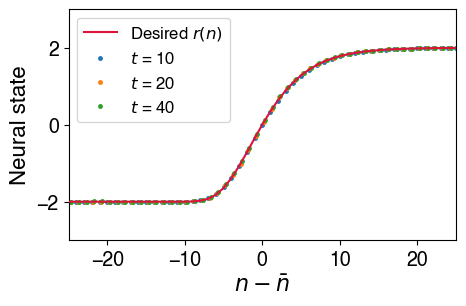

In [34]:
# compare simulated shape of edge to desired shape

plt.figure(figsize=(5,3))

nList = np.arange(0,net_asymmetric.Npopulation)
desired_edge_shape = net_asymmetric.J*(2*desiredEdgeRates(nList,edge_t,delta_z=delta_z,n_0=n_0_asymmetric)-1)
desired_edge_offset = find_edge_location(desired_edge_shape)[0]
plt.plot(nList-desired_edge_offset,desired_edge_shape,
         label='Desired $r(n)$',
         color='crimson',
         zorder=+10)

for t in [t_0_asymmetric,
          t_0_asymmetric*2,
          t_0_asymmetric*4,
         ]:
    edge_offset = np.sort(abs(find_edge_location(states_asymmetric.loc[t])))[0]
    plt.plot(nList - edge_offset,
             states_asymmetric.loc[t]['Neuron 0':'Neuron {}'.format(Npopulation-1)],
                 '.',label="$t$ = {}".format(int(t)),lw=1,ms=5)
plt.axis(xmin=-25,xmax=25,ymin=-3,ymax=+3)
plt.legend()
plt.xlabel('$n - \\bar n$')
plt.ylabel('Neural state')

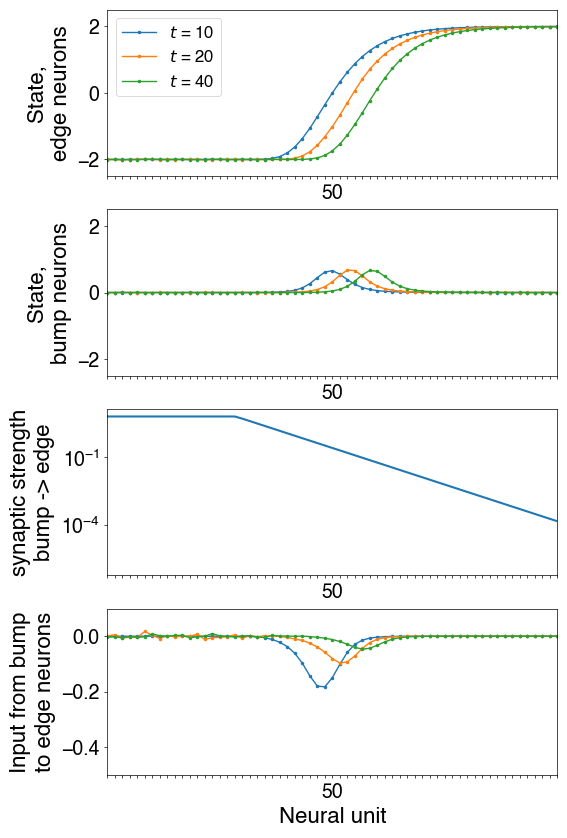

In [35]:
lf.translation_simulation_plot(net_asymmetric,states_asymmetric,states_asymmetric,n_0_asymmetric,t_0_asymmetric)
#plt.savefig('231117_self_sustained_edge_decaying_velocity.pdf')

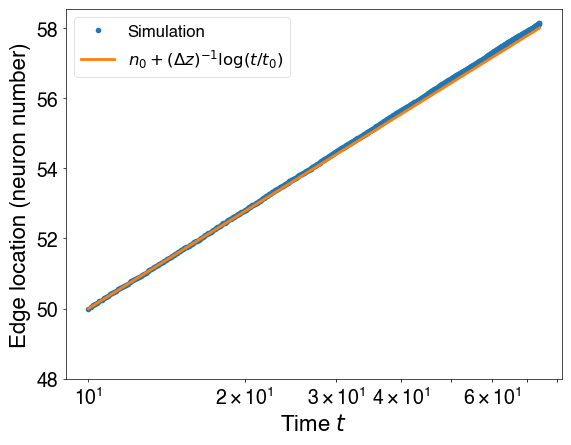

In [36]:
lf.edge_location_plot(net_asymmetric,states_asymmetric,n_0_asymmetric,t_0_asymmetric,delta_z)

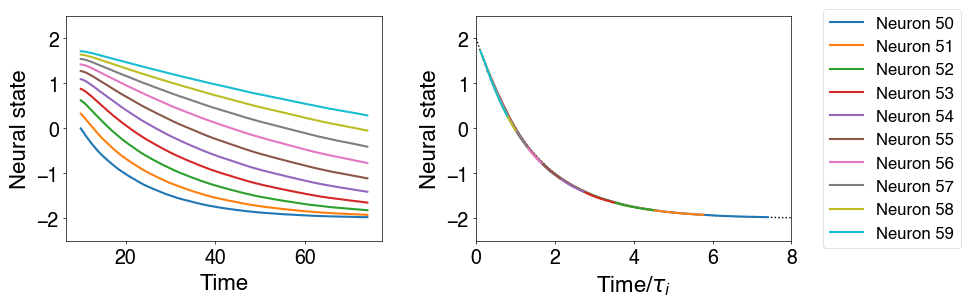

In [37]:
t_max = 80

lf.time_rescaling_plot(states_asymmetric,n_0_asymmetric,t_0_asymmetric,delta_z,t_max=t_max)

# also plot analytical result as dotted line
analytical_times = np.linspace(0,t_max,1000)
plt.plot(analytical_times/t_0_asymmetric,
         net_asymmetric.J*(2*desiredEdgeRates(n_0_asymmetric,analytical_times,n_0=n_0_asymmetric)-1),
         'k:',
         zorder=-10,
         lw=1,)
#plt.savefig('240118_firing_rate_vs_time.pdf')

# Demonstrate geometric series of timescales using symmetric kernel

In [13]:
def states2rates(states):
    return 0.5*(1.+np.tanh(states))

In [14]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

Npopulation_symmetric = 100 #50 # number of units in each population
# delta_z is the conversion unit from distance measured in number of neurons 
# to the relevant output variable z (effectively set to 1 for 231117 plots)
delta_z = 1./4. #0.5 #1 
# constant interaction strength between neighbors
J = 2 
# constant interaction from edge neurons to corresponding bump neurons
J_edge_bump = 1
# strength of feedback from bump to edge neurons varies with n
t_0_symmetric = 10
n_0_symmetric = 50  
J_bump_edge_max = 10 # to avoid instability
J_bump_edge_scale_factor_symmetric = 1 
J_bump_edge = [ -J_bump_edge_scale_factor_symmetric*min(1./t_0_symmetric*1./delta_z*np.exp(-delta_z*(n-n_0_symmetric)),
                                              J_bump_edge_max) for n in range(Npopulation_symmetric) ]
kernel_width = 2 
sigma = 1. 

net_symmetric = laplace_network(Npopulation_symmetric,J,
                      J_edge_bump=J_edge_bump,
                      J_bump_edge=J_bump_edge,
                      kernel_width=kernel_width,
                      sigma=sigma)

In [15]:
# run simulation

noise_var = 1e-6 #1e-4 (1e-4 used for 231117 plots) # 0.1 # strength of noise (variance added per unit time)
i_final = 7 #6 #5 #(t increases exponentially with i) #100 #20
t_final = t_0_symmetric + 2**(i_final-1)
delta_t = 0.01 #0.001
seed = 12345

# start with edge state at location n_0 at time t_0
edge_state = net_symmetric.find_edge_state(n_0_symmetric)
    
# simulate dynamics
states_symmetric = net_symmetric.simulate_dynamics(edge_state,
                               t_final-t_0_symmetric,
                               noise_var,
                               additional_input=None,
                               seed=seed,
                               delta_t=delta_t)
# shift times to start at t_start
states_symmetric.index = states_symmetric.index + t_0_symmetric
rates_symmetric = states2rates(states_symmetric)

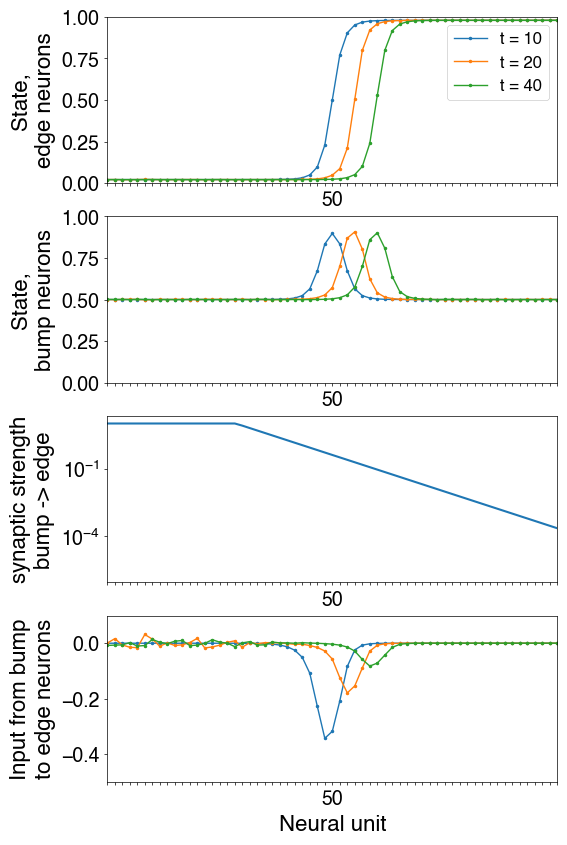

In [17]:
lf.translation_simulation_plot(net_symmetric,rates_symmetric,states_symmetric,
                            n_0_symmetric,t_0_symmetric,
                            state_min=0,state_max=1)

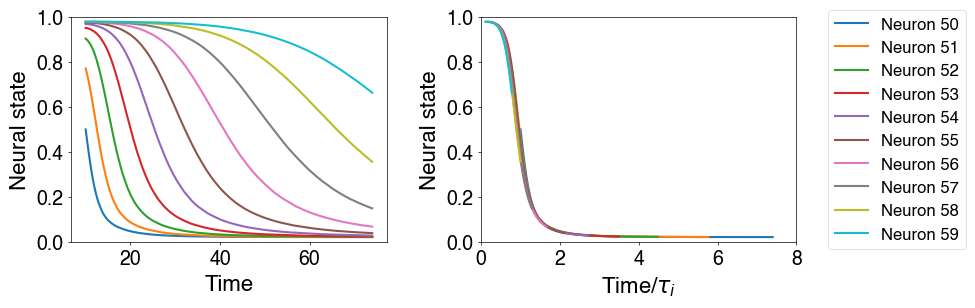

In [19]:
lf.time_rescaling_plot(rates_symmetric,n_0_symmetric,t_0_symmetric,delta_z,
                   state_min=0,state_max=1)